## IBM Quantum Challenge Fall 2021 
My path through
# Challenge 1: Optimizing your portfolio with quantum computers
 


## Challenge

<div class="alert alert-block alert-success">

**Goal**

Portfolio optimization is a crucial process for anyone who wants to maximize returns from their investments. In this first challenge, we will learn some of the basic theory behind portfolio optimization and how to formulate the problem so it can be solved by quantum computers. During the process, we will learn about Qiskit's Finance application class and methods to solve the problem efficiently.

1. **Challenge 1a**: Learn how to use the PortfolioOptimization() method in Qiskit's Finance module to convert the portfolio optimization into a quadratic program.
    
2. **Challenge 1b**: Implement VQE to solve a four-stock portfolio optimization problem based on the instance created in challenge 1a.
    
    
3. **Challenge 1c**: Solve the same problem using QAOA with three budgets and double weights for any of the assets in your portfolio. 
</div>

## Step 1. Import necessary libraries

In [1]:
#Let us begin by importing necessary libraries.
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import *
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit.utils import algorithm_globals
from qiskit_finance import QiskitFinanceError
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_optimization.algorithms import MinimumEigenOptimizer 
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import warnings
from sympy.utilities.exceptions import SymPyDeprecationWarning
warnings.simplefilter("ignore", SymPyDeprecationWarning)

## Step 2. Generate time series data (Financial Data)
Let's first generate a random time series financial data for a total number of stocks n=4. We use RandomDataProvider for this. We are going back in time and retrieve financial data from November 5, 1955 to October 26, 1985.

In [2]:
# Set parameters for assets and risk factor
num_assets = 4     # set number of assets to 4
q = 0.5                   # set risk factor to 0.5
budget = 2           # set budget as defined in the problem
seed = 132     #set random seed

# Generate time series data
stocks = [("STOCK%s" % i) for i in range(num_assets)]
data = RandomDataProvider(tickers=stocks,
                 start=datetime.datetime(1955,11,5),   
                 end=datetime.datetime(1985,10,26),  
                 seed=seed)
data.run()

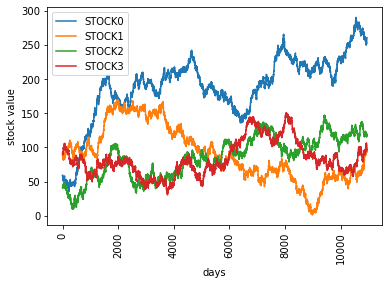

In [3]:
# Let's plot our finanical data
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('days')
plt.ylabel('stock value')
plt.show()

## Step 3. Quadratic Program Formulation

Let's generate the expected return first and then the covariance matrix which are both needed to create our portfolio.

In [4]:
#Let's calculate the expected return for our problem data

mu = data.get_period_return_mean_vector()   # Returns a vector containing the mean value of each asset's expected return.

print(mu)

[1.59702144e-04 4.76518943e-04 2.39123234e-04 9.85029012e-05]


[[ 4.88319903e-05 -1.07868619e-06 -2.12961489e-06  7.06600109e-07]
 [-1.07868619e-06  9.97360142e-04  3.51594354e-06  3.68715793e-07]
 [-2.12961489e-06  3.51594354e-06  2.87365468e-04  3.20819120e-06]
 [ 7.06600109e-07  3.68715793e-07  3.20819120e-06  1.92316728e-04]]


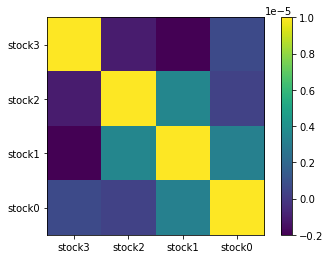

In [5]:
# Let's plot our covariance matrix Σ（sigma）
sigma = data.get_period_return_covariance_matrix() #Returns the covariance matrix of the four assets
print(sigma)
fig, ax = plt.subplots(1,1)
im = plt.imshow(sigma, extent=[-1,1,-1,1])
x_label_list = ['stock3', 'stock2', 'stock1', 'stock0']
y_label_list = ['stock3', 'stock2', 'stock1', 'stock0']
ax.set_xticks([-0.75,-0.25,0.25,0.75])
ax.set_yticks([0.75,0.25,-0.25,-0.75])
ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
plt.colorbar()
plt.clim(-0.000002, 0.00001)
plt.show()

## Challenge 1a: Create the portfolio instance using PortfolioOptimization class
<div id='u-definition'></div>
<div class="alert alert-block alert-success">

**Challenge 1a** <br>
Complete the code to generate the portfolio instance using the [**PortfolioOptimization**](https://qiskit.org/documentation/finance/stubs/qiskit_finance.applications.PortfolioOptimization.html#qiskit_finance.applications.PortfolioOptimization) class. We use the **five arguments** and their values which were obtained in the previos steps and convert the instance into a quadratic program **qp**. 
</div>

<div id='problem'></div>
<div class="alert alert-block alert-info">
    
**Note:** A binary list [1. 1. 0. 0.] indicates a portfolio consisting STOCK2 and STOCK3.
    
</div>

In [6]:
portfolio = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget)
qp = portfolio.to_quadratic_program()

print(qp)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.000159702144 x_0 - 0.000476518943 x_1 - 0.000239123234 x_2
      - 0.000098502901 x_3 + [ 0.000048831990 x_0^2 - 0.000002157372 x_0*x_1
      - 0.000004259230 x_0*x_2 + 0.000001413200 x_0*x_3 + 0.000997360142 x_1^2
      + 0.000007031887 x_1*x_2 + 0.000000737432 x_1*x_3 + 0.000287365468 x_2^2
      + 0.000006416382 x_2*x_3 + 0.000192316728 x_3^2 ]/2
Subject To
 c0: x_0 + x_1 + x_2 + x_3 = 2

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1

Binaries
 x_0 x_1 x_2 x_3
End



## Step 5. Solve with classical optimizer as a reference
Lets solve the problem. First classically...

We can now use the Operator we built above without regard to the specifics of how it was created. We set the algorithm for the NumPyMinimumEigensolver so we can have a classical reference. Backend is not required since this is computed classically not using quantum computation. The result is returned as a dictionary.

In [7]:
import time
start_time = time.time()

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)
result = exact_eigensolver.solve(qp)

print(result)

print("--- %s seconds ---" % (time.time() - start_time))

optimal function value: -0.00023285626449450202
optimal value: [1. 0. 1. 0.]
status: SUCCESS
--- 0.017981529235839844 seconds ---


The optimal value indicates our asset allocation. 

## Challenge1b: Solution using VQE

**Variational Quantum Eigensolver (VQE)** is a classical-quantum hybrid algorithm which outsources some of the processing workload to a classical computer to efficiently calculate the ground state energy (lowest energy) of a [**Hamiltonian**](https://en.wikipedia.org/wiki/Hamiltonian_(quantum_mechanics)). We can reformulate the quadratic program as a ground state energy search to be solved by [**VQE**](https://qiskit.org/documentation/stubs/qiskit.algorithms.VQE.html) where the ground state corresponds to the optimal solution we are looking for. In this challenge exercise, we will to find the optimal solution using VQE.  <br> 


<div id='u-definition'></div>
<div class="alert alert-block alert-success">

**Challenge 1b** <br>
Find the same solution by using Variational Quantum Eigensolver (VQE) to solve the problem.　We will specify the optimizer and variational form to be used.
</div>

<div id='problem'></div>

In [8]:
import time
start_time = time.time()

optimizerS = SLSQP(maxiter=1000)  
algorithm_globals.random_seed = 1234
backend = Aer.get_backend('statevector_simulator')

ry = TwoLocal(num_assets, 'ry', 'cz', reps=3, entanglement='full')
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe = VQE(ry, optimizer=optimizerS, quantum_instance=quantum_instance)

vqe_meo = MinimumEigenOptimizer(vqe)  
result = vqe_meo.solve(qp) 

print(result)   

print("--- %s seconds ---" % (time.time() - start_time))

optimal function value: -0.00023285626449450202
optimal value: [1. 0. 1. 0.]
status: SUCCESS
--- 1.3738551139831543 seconds ---


In [9]:
import time
start_time = time.time()

optimizer = SLSQP(maxiter=1000)  
algorithm_globals.random_seed = 1234
backend = Aer.get_backend('statevector_simulator')

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, 'ry', 'cz', reps=3, entanglement='full')
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)

vqe_meo = MinimumEigenOptimizer(vqe)  
result = vqe_meo.solve(qp)  

print(result) 

print("--- %s seconds ---" % (time.time() - start_time))

optimal function value: -0.00023285626449450202
optimal value: [1. 0. 1. 0.]
status: SUCCESS
--- 2.1595637798309326 seconds ---


## Challenge 1c: Portfolio optimization for B=3, n=4 stocks

In this exercise, solve the same problem where one can allocate double weights (can allocate twice the amount) for a single asset.  (For example, if we allocate twice for STOCK3 one for STOCK2, then our portfolio can be represented as [2, 1, 0, 0]. If we allocate a single weight for STOCK0, STOCK1, STOCK2 then our portfolio will look like [0, 1, 1, 1]) <br>
Furthermore, change the constraint to B=3.  With this new constraint, find the optimal portfolio that minimizes the tradeoff between risk and return.

<div id='u-definition'></div>
<div class="alert alert-block alert-success">

**Challenge 1c** <br>
Complete the code to generate the portfolio instance using the PortfolioOptimization class. <br>
Find the optimal portfolio for budget=3 where one can allocate double weights for a single asset.<br>
Use QAOA to find your optimal solution and submit your answer.
    
</div>

<div id='problem'></div>

## Step 1: Import necessary libraries

In [10]:
#Step 1: Let us begin by importing necessary libraries
import qiskit
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import *
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit.utils import algorithm_globals
from qiskit_finance import QiskitFinanceError
from qiskit_finance.applications.optimization import *
from qiskit_finance.data_providers import *
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import warnings
from sympy.utilities.exceptions import SymPyDeprecationWarning
warnings.simplefilter("ignore",SymPyDeprecationWarning)

## Step 2: Generate Time Series Data (Financial Data)

In [11]:
# Step 2. Generate time series data for four assets. 

seed = 132 
num_assets = 4
stocks = [("STOCK%s" % i) for i in range(num_assets)]
data = RandomDataProvider(tickers=stocks,
                 start=datetime.datetime(1955,11,5),   
                 end=datetime.datetime(1985,10,26),  
                 seed=seed)
data.run()

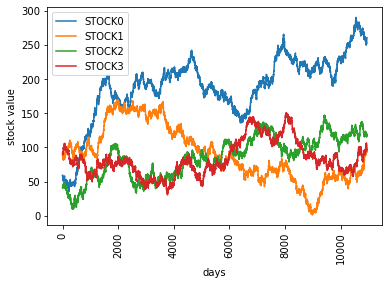

In [12]:
# Let's plot our finanical data (We are generating the same time series data as in the previous example.)
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('days')
plt.ylabel('stock value')
plt.show()

## Step 3: Calculate expected return mu and covariance sigma

In [13]:
# Step 3. Calculate mu and sigma for this problem

mu2 = data.get_period_return_mean_vector()   #Returns a vector containing the mean value of each asset.
sigma2 = data.get_period_return_covariance_matrix() #Returns the covariance matrix associated with the assets.
print(mu2, sigma2)

[1.59702144e-04 4.76518943e-04 2.39123234e-04 9.85029012e-05] [[ 4.88319903e-05 -1.07868619e-06 -2.12961489e-06  7.06600109e-07]
 [-1.07868619e-06  9.97360142e-04  3.51594354e-06  3.68715793e-07]
 [-2.12961489e-06  3.51594354e-06  2.87365468e-04  3.20819120e-06]
 [ 7.06600109e-07  3.68715793e-07  3.20819120e-06  1.92316728e-04]]


## Step 4: Set parameters and constraints based on this challenge 1c.

In [14]:
# Step 4. Set parameters and constraints based on this challenge 1c

q2 = 0.5     #Set risk factor to 0.5
budget2 = 3     #Set budget to 3
bounds = [[0,2] for x_i in range(num_assets)]

print (bounds)


[[0, 2], [0, 2], [0, 2], [0, 2]]


## Step 5: Complete code to generate the portfolio instance

In [15]:
# Step 5. Complete code to generate the portfolio instance

portfolio2 =PortfolioOptimization(expected_returns=mu2, covariances=sigma2, risk_factor=q2, budget=budget2,bounds=bounds )
qp2 = portfolio2.to_quadratic_program()

print(qp2)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.000159702144 x_0 - 0.000476518943 x_1 - 0.000239123234 x_2
      - 0.000098502901 x_3 + [ 0.000048831990 x_0^2 - 0.000002157372 x_0*x_1
      - 0.000004259230 x_0*x_2 + 0.000001413200 x_0*x_3 + 0.000997360142 x_1^2
      + 0.000007031887 x_1*x_2 + 0.000000737432 x_1*x_3 + 0.000287365468 x_2^2
      + 0.000006416382 x_2*x_3 + 0.000192316728 x_3^2 ]/2
Subject To
 c0: x_0 + x_1 + x_2 + x_3 = 3

Bounds
       x_0 <= 2
       x_1 <= 2
       x_2 <= 2
       x_3 <= 2

Generals
 x_0 x_1 x_2 x_3
End



## Step 6: Let's solve the problem using QAOA

**Quantum Approximate Optimization Algorithm (QAOA)** is another variational algorithm that has applications for solving combinatorial optimization problems on near-term quantum systems. This algorithm can also be used to calculate ground states of a Hamiltonian and can be easily implemented by using Qiskit's [**QAOA**](https://qiskit.org/documentation/stubs/qiskit.algorithms.QAOA.html) application.


In [16]:
# Step 6. Now let's use QAOA to solve this problem. 

optimizerS = SLSQP(maxiter=1000)  
algorithm_globals.random_seed = 1234
backend = Aer.get_backend('statevector_simulator')

#cobyla2 = COBYLA()
#cobyla2.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa = QAOA(optimizer=optimizerS, reps=3, quantum_instance=quantum_instance)

qaoa_meo = MinimumEigenOptimizer(qaoa) 
result2 = qaoa_meo.solve(qp2) 

print(result2) 

optimal function value: -0.0003214400383250145
optimal value: [2. 0. 1. 0.]
status: SUCCESS


# Challenge 2: Calculate bandgap of OLED molecules

## Challenge

<div class="alert alert-block alert-success">

**Goal**

The goal of this challenge is to use quantum algorithms to reliably predict the excited states energies of these TADF materials. Along the way, this challenge introduces state-of-the-art hybrid classical-quantum embedded chemistry modelling allowing the splitting of the work-load between classical approximations and more accurate quantum calculations. 
    
1. **Challenge 2a & 2b**: Understanding the atomic orbitals (AO), molecular orbitals (MO) and how to reduce the number of orbitals using active space transformation.
2. **Challenge 2c & 2d**: Calculating ground state energy of PSPCz molecule using NumPy and Variational Quantum Eigensolver (VQE).
3. **Challenge 2e**: Calculating excited state energy of PSPCz module using quantum Equation-of-Motion (QEOM) algorithm.
4. **Challenge 2f**: Running VQE on the cloud (simulator or real quantum system) using Qiskit Runtime.

</div>

### 1. Driver

The interfaces to the classical chemistry codes that are available in Qiskit are called drivers. We have for example `PSI4Driver`, `PyQuanteDriver`, `PySCFDriver` are available.

By running a driver (Hartree-Fock calculation for a given basis set and molecular geometry), in the cell below, we obtain all the necessary information about our molecule to apply then a quantum algorithm.

In [17]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver

# PSPCz molecule
geometry = [['C', [  -0.2316640,    1.1348450,    0.6956120]],
            ['C', [  -0.8886300,    0.3253780,   -0.2344140]],
            ['C', [  -0.1842470,   -0.1935670,   -1.3239330]],
            ['C', [   1.1662930,    0.0801450,   -1.4737160]],
            ['C', [   1.8089230,    0.8832220,   -0.5383540]],
            ['C', [   1.1155860,    1.4218050,    0.5392780]],
            ['S', [   3.5450920,    1.2449890,   -0.7349240]],
            ['O', [   3.8606900,    1.0881590,   -2.1541690]],
            ['C', [   4.3889120,   -0.0620730,    0.1436780]],
            ['O', [   3.8088290,    2.4916780,   -0.0174650]],
            ['C', [   4.6830900,    0.1064460,    1.4918230]],
            ['C', [   5.3364470,   -0.9144080,    2.1705280]],
            ['C', [   5.6895490,   -2.0818670,    1.5007820]],
            ['C', [   5.4000540,   -2.2323130,    0.1481350]],
            ['C', [   4.7467230,   -1.2180160,   -0.5404770]],
            ['N', [  -2.2589180,    0.0399120,   -0.0793330]],
            ['C', [  -2.8394600,   -1.2343990,   -0.1494160]],
            ['C', [  -4.2635450,   -1.0769890,    0.0660760]],
            ['C', [  -4.5212550,    0.2638010,    0.2662190]],
            ['C', [  -3.2669630,    0.9823890,    0.1722720]],
            ['C', [  -2.2678900,   -2.4598950,   -0.3287380]],
            ['C', [  -3.1299420,   -3.6058560,   -0.3236210]],
            ['C', [  -4.5179520,   -3.4797390,   -0.1395160]],
            ['C', [  -5.1056310,   -2.2512990,    0.0536940]],
            ['C', [  -5.7352450,    1.0074800,    0.5140960]],
            ['C', [  -5.6563790,    2.3761270,    0.6274610]],
            ['C', [  -4.4287740,    3.0501460,    0.5083650]],
            ['C', [  -3.2040560,    2.3409470,    0.2746950]],
            ['H', [  -0.7813570,    1.5286610,    1.5426490]],
            ['H', [  -0.7079140,   -0.7911480,   -2.0611600]],
            ['H', [   1.7161320,   -0.2933710,   -2.3302930]],
            ['H', [   1.6308220,    2.0660550,    1.2427990]],
            ['H', [   4.4214900,    1.0345500,    1.9875450]],
            ['H', [   5.5773000,   -0.7951290,    3.2218590]],
            ['H', [   6.2017810,   -2.8762260,    2.0345740]],
            ['H', [   5.6906680,   -3.1381740,   -0.3739110]],
            ['H', [   4.5337010,   -1.3031330,   -1.6001680]],
            ['H', [  -1.1998460,   -2.5827750,   -0.4596910]],
            ['H', [  -2.6937370,   -4.5881470,   -0.4657540]],
            ['H', [  -5.1332290,   -4.3740010,   -0.1501080]],
            ['H', [  -6.1752900,   -2.1516170,    0.1987120]],
            ['H', [  -6.6812260,    0.4853900,    0.6017680]],
            ['H', [  -6.5574610,    2.9529350,    0.8109620]],
            ['H', [  -4.3980410,    4.1305040,    0.5929440]],
            ['H', [  -2.2726630,    2.8838620,    0.1712760]]]

molecule = Molecule(geometry=geometry, charge=0, multiplicity=1)

driver = ElectronicStructureMoleculeDriver(molecule=molecule, 
                                           basis='631g*', 
                                           driver_type=ElectronicStructureDriverType.PYSCF)

<div class="alert alert-block alert-success">
    
**Challenge 2a**
    
Question: Find out these numbers for the PSPCz molecule.
    
1. What is the number of C, H, N, O, S atoms?
1. What is the total number of atoms?
1. What is the total number of atomic orbitals (AO)?
1. What is the total number of molecular orbitals (MO)?

</div>

In [18]:
num_ao = {
    'C': 14,
    'H': 2,
    'N': 14,
    'O': 14,
    'S': 18,
}

num_C_atom = ['C' in x for x in geometry].count(True)
num_H_atom = ['H' in x for x in geometry].count(True)
num_N_atom =['N' in x for x in geometry].count(True)
num_O_atom =['O' in x for x in geometry].count(True)
num_S_atom =['S' in x for x in geometry].count(True)
num_atoms_total = num_C_atom + num_H_atom+num_N_atom+num_O_atom+num_S_atom
num_AO_total = num_ao['C']*num_C_atom+ num_ao['H']*num_H_atom + num_ao['N']*num_N_atom + num_ao['O']*num_O_atom + num_ao['S']*num_S_atom
num_MO_total = num_AO_total

answer_ex2a ={
    'C': num_C_atom,
    'H': num_H_atom,
    'N': num_N_atom,
    'O': num_O_atom,
    'S': num_S_atom,
    'atoms': num_atoms_total,
    'AOs': num_AO_total,
    'MOs': num_MO_total
}

print(answer_ex2a)

{'C': 24, 'H': 17, 'N': 1, 'O': 2, 'S': 1, 'atoms': 45, 'AOs': 430, 'MOs': 430}


In [19]:
from qiskit_nature.drivers.second_quantization import HDF5Driver

driver_reduced = HDF5Driver("PSPCz_reduced.hdf5")
properties = driver_reduced.run()

In [20]:
from qiskit_nature.properties.second_quantization.electronic import ElectronicEnergy

electronic_energy = properties.get_property(ElectronicEnergy)
print(electronic_energy)

ElectronicEnergy
	(AO) 1-Body Terms:
		Alpha
		<(430, 430) matrix with 184900 non-zero entries>
		[0, 0] = -11.481107571585675
		[0, 1] = -2.6982522446048134
		[0, 2] = -2.237143188610541
		[0, 3] = 0.0017433998087159669
		[0, 4] = 0.0007741436199762753
		... skipping 184895 entries
		Beta
		<(430, 430) matrix with 184900 non-zero entries>
		[0, 0] = -11.481107571585675
		[0, 1] = -2.6982522446048134
		[0, 2] = -2.237143188610541
		[0, 3] = 0.0017433998087159669
		[0, 4] = 0.0007741436199762753
		... skipping 184895 entries
	(MO) 1-Body Terms:
		Alpha
		<(2, 2) matrix with 4 non-zero entries>
		[0, 0] = -0.4968112637934733
		[0, 1] = 0.00027750088691888997
		[1, 0] = 0.00027750088691825913
		[1, 1] = -0.1843594001763901
		Beta
		<(2, 2) matrix with 4 non-zero entries>
		[0, 0] = -0.4968112637934733
		[0, 1] = 0.00027750088691888997
		[1, 0] = 0.00027750088691825913
		[1, 1] = -0.1843594001763901
	(MO) 2-Body Terms:
		Alpha-Alpha
		<(2, 2, 2, 2) matrix with 16 non-zero entries>
		[0, 0,

C:\Users\artem\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<div class="alert alert-block alert-success">
    
**Challenge 2b**
    
Question: Use property framework to find out the answer for the questions below. 
    
1. What is the number of electrons in the system after active space transformation?
1. What is the number of molecular orbitals (MO)?
1. What is the number of spin orbitals (SO)?
1. How many qubits would you need to simulate this molecule with Jordan-Wigner mapping?

</div>

In [21]:
from qiskit_nature.properties.second_quantization.electronic import ParticleNumber

particle_number = properties.get_property(ParticleNumber)
print(particle_number)

ParticleNumber:
	4 SOs
	1 alpha electrons
		orbital occupation: [1. 0.]
	1 beta electrons
		orbital occupation: [1. 0.]


In [22]:
from qiskit_nature.properties.second_quantization.electronic import ParticleNumber

particle_number = properties.get_property(ParticleNumber)
num_electron = 2
num_MO = 2
num_SO = 4
num_qubits = 4

answer_ex2b = {
    'electrons': num_electron,
    'MOs': num_MO,
    'SOs': num_SO,
    'qubits': num_qubits
}

print(answer_ex2b)

{'electrons': 2, 'MOs': 2, 'SOs': 4, 'qubits': 4}


### 2. Electronic structure problem

We can then create an ElectronicStructureProblem that can produce the list of fermionic operators before mapping them to qubits (Pauli strings). This is the first step in defining your molecular system in its ground state.


In [23]:
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem

es_problem = ElectronicStructureProblem(driver_reduced)

second_q_op = es_problem.second_q_ops()
print(second_q_op[0])

Fermionic Operator
register length=4, number terms=26
  (0.01572205126528473+0j) * ( +_0 -_1 +_2 -_3 )
+ (-0.01572205126528473+0j) * ( +_0 -_1 -_2 +_3 )
+ (0.00027750088691888997+0j) * ( +_0 -_1 )
+ (0.0003149147870892302+0j) * ( +_0 -_1 +_3 -_3 )
+  ...


### 3. QubitConverter

Allows to define the mapping that we will use in the simulation.

In [24]:
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper

qubit_converter = QubitConverter(JordanWignerMapper())

qubit_op = qubit_converter.convert(second_q_op[0])
print(qubit_op)

-0.45781773131305903 * IIII
- 0.009666607989543467 * ZIII
+ 0.12689900731767084 * IZII
+ 0.030293077447785 * ZZII
- 0.009666607989543479 * IIZI
+ 0.03732964036584735 * ZIZI
+ 0.034223590264106186 * IZZI
+ 0.12689900731767084 * IIIZ
+ 0.034223590264106186 * ZIIZ
+ 0.05698995686717464 * IZIZ
+ 0.030293077447785 * IIZZ
+ 0.00014809461815615455 * XXII
+ 0.00014809461815615455 * YYII
- 7.872869677230731e-05 * XXZI
- 7.872869677230731e-05 * YYZI
+ 6.938452207544002e-05 * XXIZ
+ 6.938452207544002e-05 * YYIZ
+ 0.00014809461815615455 * IIXX
- 7.872869677230731e-05 * ZIXX
+ 6.938452207544002e-05 * IZXX
+ 0.00014809461815615455 * IIYY
- 7.872869677230731e-05 * ZIYY
+ 6.938452207544002e-05 * IZYY
+ 0.003930512816321183 * XXXX
+ 0.003930512816321183 * YYXX
+ 0.003930512816321183 * XXYY
+ 0.003930512816321183 * YYYY


C:\Users\artem\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 4. Initial state

A good initial state in chemistry is the HartreeFock state. We can initialize it as follows:

In [25]:
from qiskit_nature.circuit.library import HartreeFock

init_state = HartreeFock(num_spin_orbitals = num_SO, num_particles = particle_number.num_particles, qubit_converter = qubit_converter)

init_state.draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────

### 5. Ansatz

One of the most important choices is the quantum circuit that we choose to approximate our ground state.
Here is the example of qiskit circuit library that contains many possibilities for making your own circuit.

In [26]:
from qiskit.circuit.library import EfficientSU2, TwoLocal, NLocal, PauliTwoDesign
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

ansatz3 = EfficientSU2(num_qubits=num_qubits, reps=1, entanglement='linear', insert_barriers=True)

ansatz3.decompose().draw()

┌──────────┐┌──────────┐ ░                 ░  ┌──────────┐┌───────────┐
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[4]) ├─░───■─────────────░──┤ Ry(θ[8]) ├┤ Rz(θ[12]) ├
     ├──────────┤├──────────┤ ░ ┌─┴─┐           ░  ├──────────┤├───────────┤
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[5]) ├─░─┤ X ├──■────────░──┤ Ry(θ[9]) ├┤ Rz(θ[13]) ├
     ├──────────┤├──────────┤ ░ └───┘┌─┴─┐      ░ ┌┴──────────┤├───────────┤
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[6]) ├─░──────┤ X ├──■───░─┤ Ry(θ[10]) ├┤ Rz(θ[14]) ├
     ├──────────┤├──────────┤ ░      └───┘┌─┴─┐ ░ ├───────────┤├───────────┤
q_3: ┤ Ry(θ[3]) ├┤ Rz(θ[7]) ├─░───────────┤ X ├─░─┤ Ry(θ[11]) ├┤ Rz(θ[15]) ├
     └──────────┘└──────────┘ ░           └───┘ ░ └───────────┘└───────────┘

## Ground state energy calculation 

### Calculation using NumPy

For learning purposes, we can solve the problem exactly with the exact diagonalization of the Hamiltonian matrix so we know where to aim with VQE. Of course, the dimensions of this matrix scale exponentially in the number of molecular orbitals so we can try doing this for a large molecule of our choice and see how slow this becomes. For very large systems we would run out of memory trying to store their wavefunctions.

In [27]:
import time
start_time = time.time()

from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_nature.algorithms import GroundStateEigensolver

numpy_solver = NumPyMinimumEigensolver()
numpy_ground_state_solver = GroundStateEigensolver(qubit_converter, numpy_solver) 
numpy_results = numpy_ground_state_solver.solve(es_problem)

exact_energy = numpy_results.computed_energies[0]
print(f"Exact electronic energy: {exact_energy:.6f} Hartree\n")
print(numpy_results)

print("--- %s seconds ---" % (time.time() - start_time))

Exact electronic energy: -0.766115 Hartree

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -4043.632437386865
  - computed part:      -0.766114826773
  - ActiveSpaceTransformer extracted energy part: -4042.866322560092
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
--- 0.25247931480407715 seconds ---


### Calculation using VQE

The next step would be to use VQE to calculate this ground state energy and we would have found the solution to one half of our electronic problem!

In [28]:
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP, QNSPSA
from qiskit import Aer

backend = QasmSimulator
optimizer = COBYLA(maxiter=250)

C:\Users\artem\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import VQEUCCFactory, GroundStateEigensolver
from jupyterplot import ProgressPlot
import numpy as np
from qiskit.utils import QuantumInstance

error_threshold = 10 # mHartree

np.random.seed(5)  # fix seed for reproducibility
initial_point = np.random.random(ansatz3.num_parameters)

In [30]:
import time
start_time = time.time()

# for live plotting
pp = ProgressPlot(plot_names=['Energy'],
                  line_names=['Runtime VQE', f'Target + {error_threshold}mH', 'Target']) 

intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)
    pp.update([[energy, exact_energy+error_threshold/1000, exact_energy]])

vqe = VQE(ansatz=ansatz3,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=QuantumInstance(Aer.get_backend('aer_simulator_statevector')),
                callback=callback)
vqe_ground_state_solver = GroundStateEigensolver(qubit_converter, vqe) 
vqe_results = vqe_ground_state_solver.solve(es_problem)

print(vqe_results)

print("--- %s seconds ---" % (time.time() - start_time))

<IPython.core.display.Javascript object>

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -4043.632170029572
  - computed part:      -0.765847469479
  - ActiveSpaceTransformer extracted energy part: -4042.866322560092
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: -0.000
--- 1.4892206192016602 seconds ---


In [31]:
error = (vqe_results.computed_energies[0] - exact_energy) * 1000 # mHartree
print(f'Error is: {error:.3f} mHartree')

Error is: 0.267 mHartree


C:\Users\artem\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Excited state calculation 

### Calculation using QEOM

For the molecule of our interest we also need to compute the same but this time for the excited state of our molecular hamiltonian. Since we've already defined the system, we would now need to access the excitation energy using the quantum Equation of Motion (qEOM) algorithm which does this by solving the pseudo-eigenvalue problem with each corresponding matrix element must be measured on our quantum computer with its corresponding ground state.

In [32]:
import time
start_time = time.time()

from qiskit_nature.algorithms import QEOM

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import GroundStateEigensolver, QEOM, VQEUCCFactory

# This first part sets the ground state solver
quantum_instance1 = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))
solver1 = VQEUCCFactory(quantum_instance1)
gsc = GroundStateEigensolver(qubit_converter, solver1)

qeom_excited_state_solver = QEOM(gsc, 'sd')
qeom_results = qeom_excited_state_solver.solve(es_problem)

print(qeom_results)

print("--- %s seconds ---" % (time.time() - start_time))

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -4043.632437386191
  - computed part:      -0.766114826099
  - ActiveSpaceTransformer extracted energy part: -4042.866322560092
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -4043.426320958344
* Electronic excited state energy (Hartree): -4043.426320958345
> Total excited state energy (Hartree): -4043.426320958345
  2: 
* Electronic excited state energy (Hartree): -4043.39487437887
* Electronic excited state energy (Hartree): -4043.39487437887
> Total excited state energy (Hartree): -4043.39487437887
  3: 
* Electronic excited state energy (Hartree): -4043.085273019104
* Electronic excited state energy (Hartree): -4043.085273019105
> Total excited state energy (Hartree): -4043.085273019105
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: -0.000
--- 1.1257691383361816 seconds ---


In [33]:
bandgap = qeom_results.computed_energies[1] - qeom_results.computed_energies[0]
bandgap # in Hartree

C:\Users\artem\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.20611642784626483

# Challenge 3: Classify images with quantum machine learning

## Challenge
<div class="alert alert-block alert-success">

**Goal**

Implement a QSVM model for multiclass classification and predict labels accurately. 
    
**Plan**

First, we will learn how to construct QSVM for binary classification of a simple dataset. Then apply what we have learned to a more complex problem, 3-class classification of a different dataset.

**1. Tutorial - QSVM for binary classification of MNIST:** familiarize yourself with a typical workflow for QSVM and find the best combination of dimentions/feature maps.

**2. Challenge - QSVM for 3-class classification of Fashion-MNIST:** implement a 3-class classifier using binary QSVM classifers. Perform similar investigation as in the first part to find the best combination of dimentions/feature maps. Achieve better accuracy with smaller feature map circuits.

</div>

In [34]:
# General imports
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
from pylab import cm
import warnings

warnings.filterwarnings("ignore")

# scikit-learn imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Qiskit imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

## Part 1: Tutorial - QSVM for binary classification of MNIST

In this part, we will apply QSVM to the binary classification of handwritten numbers 4 and 9. Through this tutorial, we will learn the workflow of applying QSVM to binary classification. Find better combinations and achieve higher accuracy.

### 1. Data preparation

The data we are going to work with at the beginning is a small subset of the well known handwritten digits dataset, which is available publicly. We will be aiming to differentiate between '4' and '9'. 

There are a total of 100 data in the dataset. Of these, eighty are labeled training data, and the remaining twenty are unlabeled test data. Each data is a 28x28 image of a digit, collapsed into an array, where each element is an integer between 0 (white) and 255 (black). To use the dataset for quantum classification, we need to scale the range to between -1 and 1, and reduce the dimensionality to the number of qubits we want to use (here N_DIM=5).

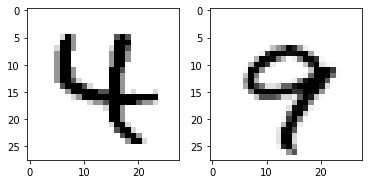

In [35]:
# Load MNIST dataset
DATA_PATH = 'ch3_part1.npz'
data = np.load(DATA_PATH)

sample_train = data['sample_train']
labels_train = data['labels_train']
sample_test = data['sample_test']

# Split train data
sample_train, sample_val, labels_train, labels_val = train_test_split(
    sample_train, labels_train, test_size=0.2, random_state=42)

# Visualize samples
fig = plt.figure()

LABELS = [4, 9]
num_labels = len(LABELS)
for i in range(num_labels):
    ax = fig.add_subplot(1, num_labels, i+1)
    img = sample_train[labels_train==LABELS[i]][0].reshape((28, 28))
    ax.imshow(img, cmap="Greys")

In [36]:
# Standardize
ss = StandardScaler()
sample_train = ss.fit_transform(sample_train)
sample_val = ss.transform(sample_val)
sample_test = ss.transform(sample_test)

# Reduce dimensions
N_DIM = 5
pca = PCA(n_components=N_DIM)
sample_train = pca.fit_transform(sample_train)
sample_val = pca.transform(sample_val)
sample_test = pca.transform(sample_test)

# Normalize
mms = MinMaxScaler((-1, 1))
sample_train = mms.fit_transform(sample_train)
sample_val = mms.transform(sample_val)
sample_test = mms.transform(sample_test)

### 2. Data Encoding

We will take the classical data and encode it to the quantum state space using a quantum feature map. The choice of which feature map to use is important and may depend on the given dataset we want to classify.

### 2.1 Quantum Feature Maps

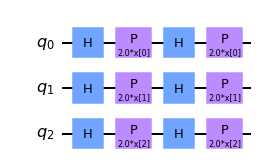

In [37]:
# 3 features, depth 2
map_z = ZFeatureMap(feature_dimension=3, reps=2)
map_z.decompose().draw('mpl')

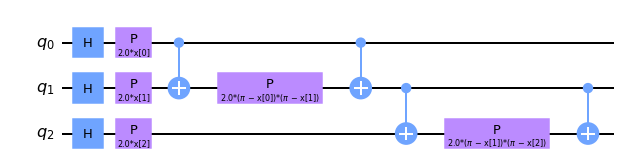

In [38]:
# 3 features, depth 1, linear entanglement
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='linear')
map_zz.decompose().draw('mpl')

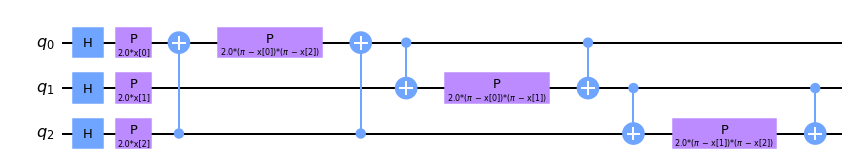

In [39]:
# 3 features, depth 1, circular entanglement
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='circular')
map_zz.decompose().draw('mpl')

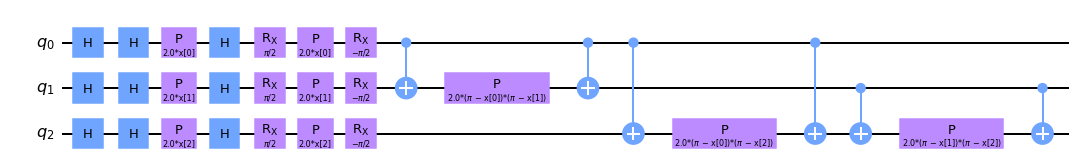

In [40]:
# 3 features, depth 1
map_pauli = PauliFeatureMap(feature_dimension=3, reps=1, paulis = ['X', 'Y', 'ZZ'])
map_pauli.decompose().draw('mpl')

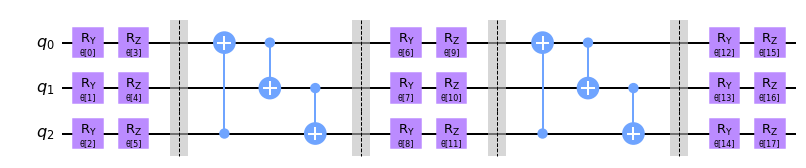

In [41]:
twolocal = TwoLocal(num_qubits=3, reps=2, rotation_blocks=['ry','rz'], 
               entanglement_blocks='cx', entanglement='circular', insert_barriers=True)
twolocal.decompose().draw('mpl')

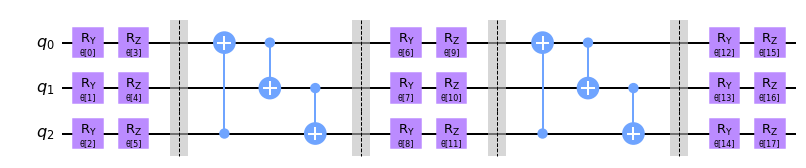

In [42]:
twolocaln = NLocal(num_qubits=3, reps=2,
               rotation_blocks=[RYGate(Parameter('a')), RZGate(Parameter('a'))], 
               entanglement_blocks=CXGate(), 
               entanglement='circular', insert_barriers=True)
twolocaln.decompose().draw('mpl')

In [43]:
print(f'First training data: {sample_train[0]}')

First training data: [-0.47556161 -0.42256069  0.30042758  0.00512653 -0.89424293]


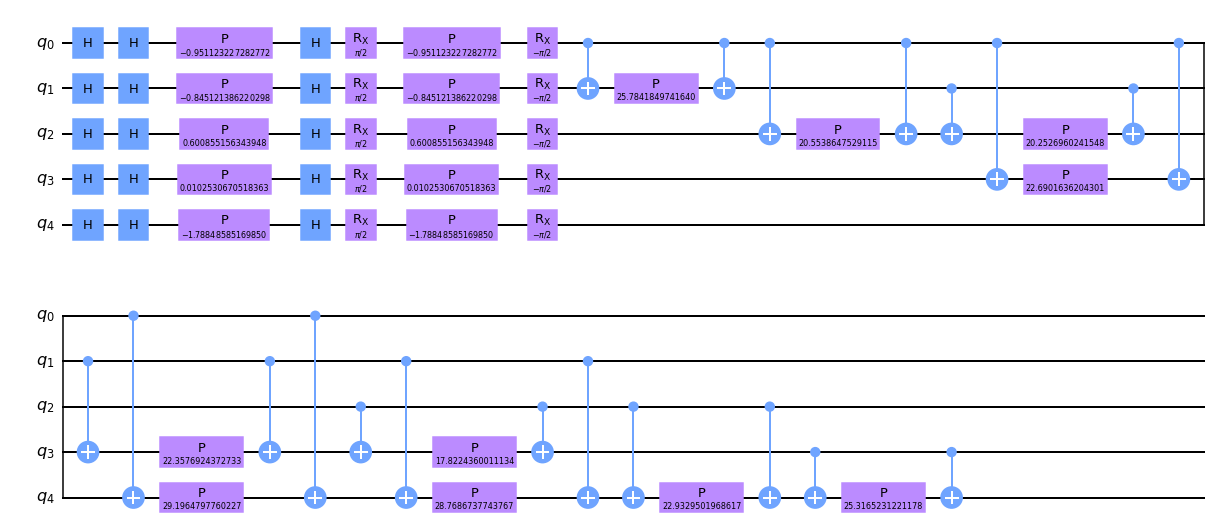

In [44]:
encode_map = PauliFeatureMap(feature_dimension=N_DIM, reps=1, paulis = ['X', 'Y', 'ZZ'])
encode_circuit = encode_map.bind_parameters(sample_train[0])
encode_circuit.decompose().draw(output='mpl')

<div class="alert alert-block alert-success">

**Challenge 3a**

Construct a feature map to encode a 5-dimensionally embedded data, using 'ZZFeatureMap' with 3 repetitions, 'circular' entanglement and the rest as default.
    
</div>

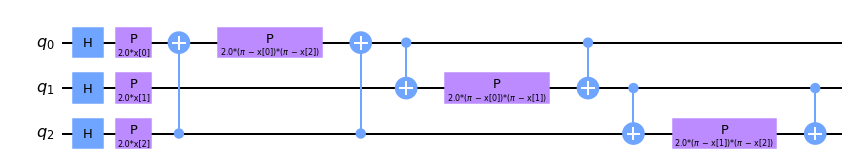

In [45]:
ex3a_fmap = ZZFeatureMap(feature_dimension=5, reps=3, entanglement='circular')
map_zz.decompose().draw('mpl')

### 2.2 Quantum Kernel Estimation

In [46]:
pauli_map = PauliFeatureMap(feature_dimension=N_DIM, reps=1, paulis = ['X', 'Y', 'ZZ'])
pauli_kernel = QuantumKernel(feature_map=pauli_map, quantum_instance=Aer.get_backend('statevector_simulator'))

In [47]:
print(f'First training data : {sample_train[0]}')
print(f'Second training data: {sample_train[1]}')

First training data : [-0.47556161 -0.42256069  0.30042758  0.00512653 -0.89424293]
Second training data: [ 0.0525892  -0.67206606 -0.28172358  0.02276232 -0.38607433]


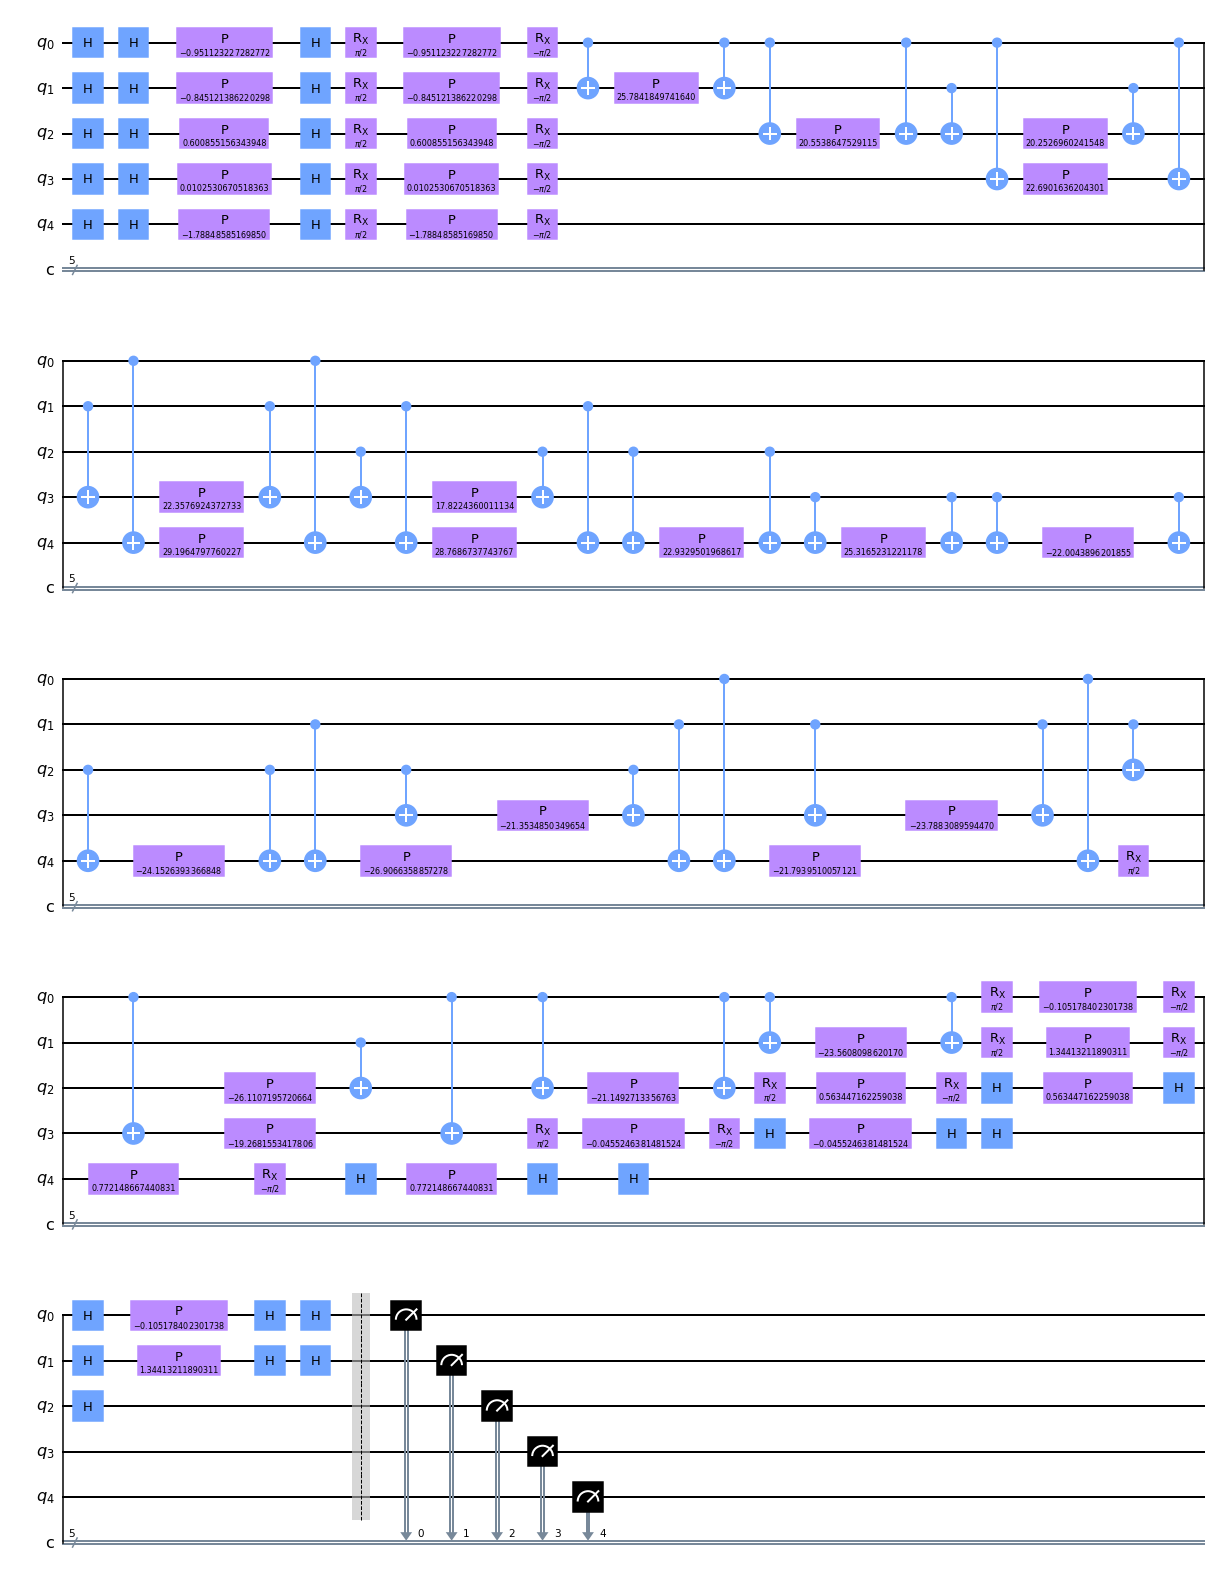

In [48]:
pauli_circuit = pauli_kernel.construct_circuit(sample_train[0], sample_train[1])
pauli_circuit.decompose().decompose().draw(output='mpl')

In [49]:
backend = Aer.get_backend('qasm_simulator')
job = execute(pauli_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(pauli_circuit)

The transition amplitude is the proportion of counts in the zero state

In [50]:
print(f"Transition amplitude: {counts['0'*N_DIM]/sum(counts.values())}") 

Transition amplitude: 0.0281982421875


This process is then repeated for each pair of training data samples to fill in the training kernel matrix, and between each training and testing data sample to fill in the testing kernel matrix. Note that each matrix is symmetric, so to reduce computation time, only half the entries are calculated explicitly. 

Here we compute and plot the training and testing kernel matrices:

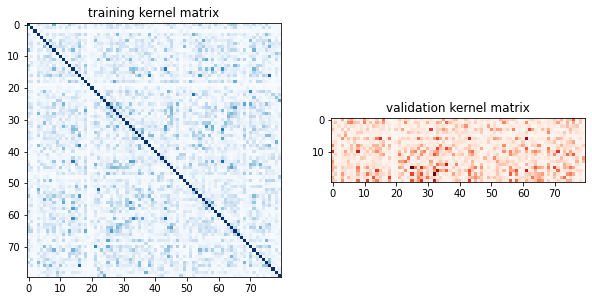

In [51]:
matrix_train = pauli_kernel.evaluate(x_vec=sample_train)
matrix_val = pauli_kernel.evaluate(x_vec=sample_val, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_val),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("validation kernel matrix")
plt.show()

<div class="alert alert-block alert-success">

**Challenge 3b**

Calculate the transition amplitude between $x = (-0.5, -0.4, 0.3, 0, -0.9)$ and $y = (0, -0.7, -0.3, 0, -0.4)$ using the 'ZZFeatureMap' with 3 repetitions, 'circular' entanglement and the rest as default. Use the 'qasm_simulator' with 'shots=8192', `seed_simulator=1024` and `seed_transpiler=1024`.
    
</div>

In [52]:
x = [-0.5, -0.4, 0.3, 0, -0.9]
y = [0, -0.7, -0.3, 0, -0.4]

zz_kernel = QuantumKernel(feature_map=ex3a_fmap, quantum_instance=Aer.get_backend('statevector_simulator'))
zz_circuit = zz_kernel.construct_circuit(x, y)
zz_circuit.decompose().decompose().draw(output='mpl')
backend = Aer.get_backend('qasm_simulator')
job = execute(zz_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(zz_circuit)
ex3b_amp=counts['00000']/sum(counts.values())
print(ex3b_amp)

0.0068359375


### 2.3 Quantum Support Vector Machine (QSVM)

The quantum kernel support vector classification algorithm consists of these steps:
1. Build the train and test quantum kernel matrices.
2. Use the train and test quantum kernel matrices in a classical support vector machine classification algorithm.

In [53]:
pauli_svc = SVC(kernel='precomputed')
pauli_svc.fit(matrix_train, labels_train)
pauli_score = pauli_svc.score(matrix_val, labels_val)

print(f'Precomputed kernel classification test score: {pauli_score*100}%')

Precomputed kernel classification test score: 70.0%


## Part 2: Challenge - QSVM for 3-class classification of Fashion-MNIST

In this part, we will use what our have learned so far to implement 3-class classification of clothing images and work on improving its accuracy. 
    
<div class="alert alert-block alert-success">

**Challenge 3c**

**Goal**: Implement a 3-class classifier using QSVM and achieve 70% accuracy on clothing image dataset with smaller feature map circuits.

**Dataset**: Fashion-MNIST clothing image dataset. There are following three dataset in this challnge.  
- Train: Both images and labels are given.
- Public test: Images are given and labels are hidden.
- Private test: Both images and labels are hidden.
    
Grading will be performed on both public test and private test data. The purpose of this is to make sure that quantum methods are used, so that cheating is not possible.
    
</div>

### 1. Data preparation
The data we are working with here is a small subset of clothing image dataset called Fashion-MNIST, which is a variant of the MNIST dataset. We aim to classify the following labels.
- label 0: T-shirt/top
- label 2: pullover
- label 3: dress

First, let's load the dataset and display one image for each class.

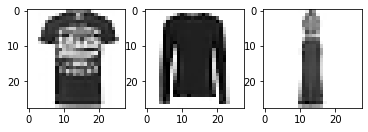

In [54]:
# Load MNIST dataset
DATA_PATH = 'ch3_part2.npz'
data = np.load(DATA_PATH)

sample_train = data['sample_train']
labels_train = data['labels_train']
sample_test = data['sample_test']

# Split train data
sample_train, sample_val, labels_train, labels_val = train_test_split(
    sample_train, labels_train, test_size=0.2, random_state=42)

# Visualize samples
fig = plt.figure()

LABELS = [0, 2, 3]
num_labels = len(LABELS)
for i in range(num_labels):
    ax = fig.add_subplot(1, num_labels, i+1)
    img = sample_train[labels_train==LABELS[i]][0].reshape((28, 28))
    ax.imshow(img, cmap="Greys")

In [55]:
# Standardize
standard_scaler = StandardScaler()
sample_train = standard_scaler.fit_transform(sample_train)
sample_val = standard_scaler.transform(sample_val)
sample_test = standard_scaler.transform(sample_test)

# Reduce dimensions
N_DIM = 5
pca = PCA(n_components=N_DIM)
sample_train = pca.fit_transform(sample_train)
sample_val = pca.transform(sample_val)
sample_test = pca.transform(sample_test)

# Normalize
min_max_scaler = MinMaxScaler((-1, 1))
sample_train = min_max_scaler.fit_transform(sample_train)
sample_val = min_max_scaler.transform(sample_val)
sample_test = min_max_scaler.transform(sample_test)

### 2. Modeling
Based on the One-vs-Rest approach, we need to create the following three QSVM binary classifiers
- the label 0 and the rest
- the label 2 and the rest
- the label 3 and the rest

### 2.1: Label 0 vs Rest
Create new labels with label 0 as positive(1) and the rest as negative(0) as follows.

In [56]:
labels_train_0 = np.where(labels_train==0, 1, 0)
labels_val_0 = np.where(labels_val==0, 1, 0)

print(f'Original validation labels:      {labels_val}')
print(f'Validation labels for 0 vs Rest: {labels_val_0}')

Original validation labels:      [3 3 2 0 3 0 3 2 3 2 2 3 2 2 2 3 0 2 3 3]
Validation labels for 0 vs Rest: [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


See only places where the original label was 0 are set to 1.  

Next, construct a binary classifier using QSVM as before.  

In [57]:
pauli_map_0 = PauliFeatureMap(feature_dimension=N_DIM, reps=4, paulis = ['X', 'Y'])
pauli_kernel_0 = QuantumKernel(feature_map=pauli_map_0, quantum_instance=Aer.get_backend('statevector_simulator'))

pauli_svc_0 = SVC(kernel='precomputed', probability=True)

matrix_train_0 = pauli_kernel_0.evaluate(x_vec=sample_train)
pauli_svc_0.fit(matrix_train_0, labels_train_0)

matrix_val_0 = pauli_kernel_0.evaluate(x_vec=sample_val, y_vec=sample_train)
pauli_score_0 = pauli_svc_0.score(matrix_val_0, labels_val_0)
print(f'Accuracy of discriminating between label 0 and others: {pauli_score_0*100}%')

Accuracy of discriminating between label 0 and others: 95.0%


We can see that the QSVM binary classifier is able to distinguish between label 0 and the rest with a reasonable probability.

Finally, for each of the test data, calculate the probability that it has label 0.

In [58]:
matrix_test_0 = pauli_kernel_0.evaluate(x_vec=sample_test, y_vec=sample_train)
pred_0 = pauli_svc_0.predict_proba(matrix_test_0)[:, 1]
print(f'Probability of label 0: {np.round(pred_0, 2)}')

Probability of label 0: [0.83 0.79 0.08 0.28 0.05 0.06 0.82 0.14 0.83 0.84 0.19 0.57 0.15 0.17
 0.17 0.08 0.18 0.62 0.12 0.43]


### 2.2: Label 2 vs Rest
Build a binary classifier using QSVM and get the probability of label 2 for test dataset.

In [59]:
labels_train_2 = np.where(labels_train==2, 1, 0)
labels_val_2 = np.where(labels_val==2, 1, 0)
print(f'Original validation labels:      {labels_val}')
print(f'Validation labels for 2 vs Rest: {labels_val_2}')

pauli_map_2 = PauliFeatureMap(feature_dimension=N_DIM, reps=3, paulis = ['X', 'Y'])
pauli_kernel_2 = QuantumKernel(feature_map=pauli_map_2, quantum_instance=Aer.get_backend('statevector_simulator'))

pauli_svc_2 = SVC(kernel='precomputed', probability=True)

matrix_train_2 = pauli_kernel_2.evaluate(x_vec=sample_train)
pauli_svc_2.fit(matrix_train_2, labels_train_2)

matrix_val_2 = pauli_kernel_2.evaluate(x_vec=sample_val, y_vec=sample_train)
pauli_score_2 = pauli_svc_2.score(matrix_val_2, labels_val_2)
print(f'Accuracy of discriminating between label 2 and others: {pauli_score_2*100}%')

matrix_test_2 = pauli_kernel_2.evaluate(x_vec=sample_test, y_vec=sample_train)
pred_2 = pauli_svc_2.predict_proba(matrix_test_2)[:, 1]
print(f'Probability of label 2: {np.round(pred_2, 2)}')

Original validation labels:      [3 3 2 0 3 0 3 2 3 2 2 3 2 2 2 3 0 2 3 3]
Validation labels for 2 vs Rest: [0 0 1 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0]
Accuracy of discriminating between label 2 and others: 100.0%
Probability of label 2: [0.04 0.03 0.04 0.08 0.24 0.07 0.03 0.38 0.03 0.07 0.06 0.23 0.96 0.69
 0.05 0.97 0.07 0.03 0.06 0.34]


### 2.3 Label 3 vs Rest
Build a binary classifier using QSVM and get the probability of label 3 for test dataset.

In [60]:
labels_train_3 = np.where(labels_train==3, 1, 0)
labels_val_3 = np.where(labels_val==3, 1, 0)
print(f'Original validation labels:      {labels_val}')
print(f'Validation labels for 3 vs Rest: {labels_val_3}')

pauli_map_3 = PauliFeatureMap(feature_dimension=N_DIM, reps=3, paulis = ['X', 'Y'])
pauli_kernel_3 = QuantumKernel(feature_map=pauli_map_3, quantum_instance=Aer.get_backend('statevector_simulator'))

pauli_svc_3 = SVC(kernel='precomputed', probability=True)

matrix_train_3 = pauli_kernel_3.evaluate(x_vec=sample_train)
pauli_svc_3.fit(matrix_train_3, labels_train_3)

matrix_val_3 = pauli_kernel_3.evaluate(x_vec=sample_val, y_vec=sample_train)
pauli_score_3 = pauli_svc_3.score(matrix_val_3, labels_val_3)
print(f'Accuracy of discriminating between label 3 and others: {pauli_score_3*100}%')

matrix_test_3 = pauli_kernel_3.evaluate(x_vec=sample_test, y_vec=sample_train)
pred_3 = pauli_svc_3.predict_proba(matrix_test_3)[:, 1]
print(f'Probability of label 3: {np.round(pred_3, 2)}')

Original validation labels:      [3 3 2 0 3 0 3 2 3 2 2 3 2 2 2 3 0 2 3 3]
Validation labels for 3 vs Rest: [1 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1]
Accuracy of discriminating between label 3 and others: 95.0%
Probability of label 3: [0.07 0.08 0.61 0.59 0.48 0.96 0.14 0.08 0.09 0.11 0.64 0.13 0.06 0.08
 0.65 0.06 0.77 0.12 0.94 0.08]


### 3. Prediction
Lastly, make a final prediction based on the probability of each label.  

In [61]:
sample_pred = np.load('ch3_part2_sub.npy')
print(f'Sample prediction: {sample_pred}')

Sample prediction: [0 0 0 0 0 0 2 2 2 2 2 2 3 3 3 3 3 3 3 3]


In order to understand the method to make predictions for multiclass classification, let's begin with the case of making predictions for just two labels, label 2 and label 3.

If probabilities are as follows for a certain data, label 2 should be considered the most plausible.
- probability of label 2: 0.7
- probability of label 3: 0.2

In [62]:
pred_2_ex = np.array([0.7])
pred_3_ex = np.array([0.2])

pred_test_ex = np.where((pred_2_ex > pred_3_ex), 2, 3)
print(f'Prediction: {pred_test_ex}')

Prediction: [2]


We can apply this method as is to multiple data.

If second data has probabilities for each label as follows, it should be classified as label 3.
- probability of label 2: 0.1
- probability of label 3: 0.6

In [63]:
pred_2_ex = np.array([0.7, 0.1])
pred_3_ex = np.array([0.2, 0.6])

pred_test_ex = np.where((pred_2_ex > pred_3_ex), 2, 3)
print(f'Prediction: {pred_test_ex}')

Prediction: [2 3]


This method can be extended to make predictions for 3-class classification.

In [64]:
pred_2_ex = np.array([0.1])
pred_3_ex = np.array([0.2])
pred_0_ex = np.array([0.7])

def pred(x,y,z):
    if x>y and x>z:
        return 0
    if y>x and y>z:
        return 2
    if z>x and z>y:
        return 3


pred_test = pred(pred_0_ex, pred_2_ex, pred_3_ex)
print(f'Prediction: {pred_test}')

Prediction: 0


In [65]:
pred_2_ex = np.array([0.1, 0.6, 0.3])
pred_3_ex = np.array([0.2, 0.1, 0.5])
pred_0_ex = np.array([0.7, 0.3, 0.2])

def pred(x,y,z):
    a=[]
    for i in range(len(x)):
        if x[i]>y[i] and x[i]>z[i]:
            a.append(0)
        elif y[i]>x[i] and y[i]>z[i]:
            a.append(2)
        elif z[i]>x[i] and z[i]>y[i]:
            a.append(3)
    return a


pred_test1 = pred(pred_0_ex, pred_2_ex, pred_3_ex)
print(f'Prediction: {pred_test1}')

Prediction: [0, 2, 3]


In [66]:
labels_train_0 = np.where(labels_train==0, 1, 0)
labels_val_0 = np.where(labels_val==0, 1, 0)
print(f'Original validation labels:      {labels_val}')
print(f'Validation labels for 0 vs Rest: {labels_val_0}')

pauli_map_0 = PauliFeatureMap(feature_dimension=N_DIM, reps=4, paulis = ['X', 'Y'])
kernel_0 = QuantumKernel(feature_map=pauli_map_2, quantum_instance=Aer.get_backend('statevector_simulator'))

svc_0 = SVC(kernel='precomputed', probability=True)

matrix_train_0 = kernel_0.evaluate(x_vec=sample_train)
svc_0.fit(matrix_train_0, labels_train_0)

matrix_val_0 = kernel_0.evaluate(x_vec=sample_val, y_vec=sample_train)
pauli_score_0 = svc_0.score(matrix_val_0, labels_val_0)
print(f'Accuracy of discriminating between label 0 and others: {pauli_score_0*100}%')

matrix_test_0 = kernel_0.evaluate(x_vec=sample_test, y_vec=sample_train)
pred_0 = svc_0.predict_proba(matrix_test_0)[:, 1]
print(f'Probability of label 0: {np.round(pred_0, 2)}')




labels_train_2 = np.where(labels_train==2, 1, 0)
labels_val_2 = np.where(labels_val==2, 1, 0)
print(f'Original validation labels:      {labels_val}')
print(f'Validation labels for 2 vs Rest: {labels_val_2}')

pauli_map_2 = PauliFeatureMap(feature_dimension=N_DIM, reps=3, paulis = ['X', 'Y'])
kernel_2 = QuantumKernel(feature_map=pauli_map_2, quantum_instance=Aer.get_backend('statevector_simulator'))

svc_2 = SVC(kernel='precomputed', probability=True)

matrix_train_2 = kernel_2.evaluate(x_vec=sample_train)
svc_2.fit(matrix_train_2, labels_train_2)

matrix_val_2 = kernel_2.evaluate(x_vec=sample_val, y_vec=sample_train)
pauli_score_2 = svc_2.score(matrix_val_2, labels_val_2)
print(f'Accuracy of discriminating between label 2 and others: {pauli_score_2*100}%')

matrix_test_2 = kernel_2.evaluate(x_vec=sample_test, y_vec=sample_train)
pred_2 = svc_2.predict_proba(matrix_test_2)[:, 1]
print(f'Probability of label 2: {np.round(pred_2, 2)}')



labels_train_3 = np.where(labels_train==3, 1, 0)
labels_val_3 = np.where(labels_val==3, 1, 0)
print(f'Original validation labels:      {labels_val}')
print(f'Validation labels for 3 vs Rest: {labels_val_3}')

pauli_map_3 = PauliFeatureMap(feature_dimension=N_DIM, reps=3, paulis = ['X', 'Y'])
kernel_3 = QuantumKernel(feature_map=pauli_map_3, quantum_instance=Aer.get_backend('statevector_simulator'))

svc_3 = SVC(kernel='precomputed', probability=True)

matrix_train_3 = kernel_3.evaluate(x_vec=sample_train)
svc_3.fit(matrix_train_3, labels_train_3)

matrix_val_3 = kernel_3.evaluate(x_vec=sample_val, y_vec=sample_train)
pauli_score_3 = svc_3.score(matrix_val_3, labels_val_3)
print(f'Accuracy of discriminating between label 3 and others: {pauli_score_3*100}%')

matrix_test_3 = kernel_3.evaluate(x_vec=sample_test, y_vec=sample_train)
pred_3 =svc_3.predict_proba(matrix_test_3)[:, 1]
print(f'Probability of label 3: {np.round(pred_3, 2)}')


Original validation labels:      [3 3 2 0 3 0 3 2 3 2 2 3 2 2 2 3 0 2 3 3]
Validation labels for 0 vs Rest: [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Accuracy of discriminating between label 0 and others: 95.0%
Probability of label 0: [0.96 0.96 0.35 0.17 0.11 0.02 0.83 0.38 0.95 0.71 0.21 0.37 0.04 0.35
 0.28 0.04 0.11 0.91 0.03 0.42]
Original validation labels:      [3 3 2 0 3 0 3 2 3 2 2 3 2 2 2 3 0 2 3 3]
Validation labels for 2 vs Rest: [0 0 1 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0]
Accuracy of discriminating between label 2 and others: 100.0%
Probability of label 2: [0.04 0.03 0.04 0.1  0.27 0.08 0.04 0.4  0.03 0.08 0.07 0.25 0.96 0.7
 0.05 0.96 0.08 0.04 0.08 0.36]
Original validation labels:      [3 3 2 0 3 0 3 2 3 2 2 3 2 2 2 3 0 2 3 3]
Validation labels for 3 vs Rest: [1 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1]
Accuracy of discriminating between label 3 and others: 95.0%
Probability of label 3: [0.06 0.07 0.6  0.59 0.47 0.96 0.12 0.07 0.08 0.1  0.63 0.12 0.05 0.07
 0.64 0.05 0.77 0.

In [67]:
pred_test = pred(pred_0, pred_2, pred_3)

pred_test = np.array(pred_test)
print(f'Prediction: {pred_test}')

Prediction: [0 0 3 3 3 3 0 2 0 0 3 0 2 2 3 2 3 0 3 0]


# Challenge 4: Battery revenue optimization

<div class="alert alert-block alert-success">

**Goal**

Implement the quantum optimization code for the battery revenue problem. <br>
</div>

As we just mentioned, QAOA is an algorithm which can be used to find approximate solutions to combinatorial optimization problems, which includes many specific problems, such as:

- TSP (Traveling Salesman Problem) problem
- Vehicle routing problem
- Set cover problem
- Knapsack problem
- Scheduling problems,etc. 

Some of them are hard to solve (or in another word, they are NP-hard problems), and it is impractical to find their exact solutions in a reasonable amount of time, and that is why we need the approximate algorithm. Next, we will introduce an instance of using QAOA to solve one of the combinatorial optimization problems----**knapsack problem**.

# Knapsack Problem #

**Knapsack Problem** is an optimization problem that goes like this: given a list of items that each has a weight and a value and a knapsack that can hold a maximum weight. Determine which items to take in the knapsack so as to maximize the total value taken without exceeding the maiximum weight the knapsack can hold. The most efficient approach would be a greedy approach, but that is not guaranteed to give the best result.

## Challenge 4a: Simple knapsack problem with QAOA 

<div class="alert alert-block alert-success">
    
**Challenge 4a** <br>
We are given a knapsack with a capacity of 18 and 5 pieces of luggage. When the weights of each piece of luggage $W$ is $w_i = [4,5,6,7,8]$ and the value $V$ is $v_i = [5,6,7,8,9]$, find the packing method that maximizes the sum of the values of the luggage within the capacity limit of 18.


</div>

In [68]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit import Aer
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
import numpy as np

## Dynamic Programming Approach ##

A typical classical method for finding an exact solution, the Dynamic Programming approach is as follows:

In [69]:
val = [5,6,7,8,9]
wt = [4,5,6,7,8]
W = 18

In [70]:
import time
start_time = time.time()

def dp(W, wt, val, n):
    k = [[0 for x in range(W + 1)] for x in range(n + 1)]
    for i in range(n + 1):
        for w in range(W + 1):
            if i == 0 or w == 0:
                k[i][w] = 0
            elif wt[i-1] <= w:
                k[i][w] = max(val[i-1] + k[i-1][w-wt[i-1]], k[i-1][w])
            else:
                k[i][w] = k[i-1][w]
                
    picks=[0 for x in range(n)]
    volume=W
    for i in range(n,-1,-1):
        if (k[i][volume]>k[i-1][volume]):
            picks[i-1]=1
            volume -= wt[i-1]
    return k[n][W],picks

n = len(val)
print("optimal value:", dp(W, wt, val, n)[0])
print('\n index of the chosen items:')
for i in range(n): 
    if dp(W, wt, val, n)[1][i]: 
        print(i,end=' ')     
        
print("--- %s seconds ---" % (time.time() - start_time))

optimal value: 21

 index of the chosen items:
1 2 3 --- 0.0009686946868896484 seconds ---


## QAOA approach ##

Qiskit provides application classes for various optimization problems, including the knapsack problem so that users can easily try various optimization problems on quantum computers. In this exercise, we are going to use the application classes for the `Knapsack` problem here. 

In [71]:
# import packages necessary for application classes.
from qiskit_optimization.applications import Knapsack

In [72]:
import time
start_time = time.time()

def knapsack_quadratic_program():        
    prob = Knapsack(values = val, weights = wt, max_weight=W)       
    # to_quadratic_program generates a corresponding QuadraticProgram of the instance of the knapsack problem.
    kqp = prob.to_quadratic_program()
    return prob, kqp

prob,quadratic_program=knapsack_quadratic_program()
quadratic_program

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.006902456283569336 seconds ---


In [73]:
import time
start_time = time.time()

# Numpy Eigensolver
meo = MinimumEigenOptimizer(min_eigen_solver=NumPyMinimumEigensolver())
result = meo.solve(quadratic_program)
print('result:\n', result)
print('\n index of the chosen items:', prob.interpret(result)) 

print("--- %s seconds ---" % (time.time() - start_time))

result:
 optimal function value: 21.0
optimal value: [0. 1. 1. 1. 0.]
status: SUCCESS

 index of the chosen items: [1, 2, 3]
--- 0.05684828758239746 seconds ---


In [74]:
import time
start_time = time.time()

# QAOA
seed = 123
algorithm_globals.random_seed = seed
qins = QuantumInstance(backend=Aer.get_backend('qasm_simulator'), shots=1000, seed_simulator=seed, seed_transpiler=seed)

meo = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=1, quantum_instance=qins))
result = meo.solve(quadratic_program)
print('result:\n', result)
print('\n index of the chosen items:', prob.interpret(result)) 

print("--- %s seconds ---" % (time.time() - start_time))

result:
 optimal function value: 21.0
optimal value: [0. 1. 1. 1. 0.]
status: SUCCESS

 index of the chosen items: [1, 2, 3]
--- 5.6253767013549805 seconds ---


# Battery Revenue Optimization Problem #

<div class="alert alert-block alert-success">
In this exercise we will use a quantum algorithm to solve a real-world instance of a combinatorial optimization problem: Battery revenue optimization problem.   
</div>

Battery storage systems have provided a solution to flexibly integrate large-scale renewable energy (such as wind and solar) in a power system. The revenues from batteries come from different types of services sold to the grid. The process of energy trading of battery storage assets is as follows: A regulator asks each battery supplier to choose a market in advance for each time window. Then, the batteries operator will charge the battery with renewable energy and release the energy to the grid depending on pre-agreed contracts. The supplier makes therefore forecasts on the return and the number of charge/discharge cycles for each time window to optimize its overall return. 

How to maximize the revenue of battery-based energy storage is a concern of all battery storage investors. Choose to let the battery always supply power to the market which pays the most for every time window might be a simple guess, but in reality, we have to consider many other factors. 

What we can not ignore is the aging of batteries, also known as **degradation**. As the battery charge/discharge cycle progresses, the battery capacity will gradually degrade (the amount of energy a battery can store, or the amount of power it can deliver will permanently reduce). After a number of cycles, the battery will reach the end of its usefulness. Since the performance of a battery decreases while it is used, choosing the best cash return for every time window one after the other, without considering the degradation, does not lead to an optimal return over the lifetime of the battery, i.e. before the number of charge/discharge cycles reached.

Therefore, in order to optimize the revenue of the battery, what we have to do is to select the market for the battery in each time window taking both **the returns on these markets (value)**, based on price forecast, as well as expected battery **degradation over time (cost)** into account ——It sounds like solving a common optimization problem, right?

We will investigate how quantum optimization algorithms could be adapted to tackle this problem.

# Challenge 4b: Battery revenue optimization with Qiskit knapsack class #

<div class="alert alert-block alert-success">

**Challenge 4b** <br>
We will optimize the battery schedule using Qiskit optimization knapsack class with QAOA to maximize the total return with a cost within $C_{max}$ under the following conditions;
    <br>
- the time window $t = 7$<br>
- the daily return $\lambda_{1} = [5, 3, 3, 6, 9, 7, 1]$<br>
- the daily return $\lambda_{2} = [8, 4, 5, 12, 10, 11, 2]$<br>
- the daily degradation for the battery $c_{1} = [1, 1, 2, 1, 1, 1, 2]$<br>
- the daily degradation for the battery $c_{2} = [3, 2, 3, 2, 4, 3, 3]$<br>
- $C_{max} = 16$<br>
<br>
    
Our task is to find the argument, `values`, `weights`, and `max_weight` used for the Qiskit optimization knapsack class, to get a solution which "0" denote the choice of market $M_{1}$, and "1" denote the choice of market $M_{2}$.
    <br>

</div>

In [75]:
L1 = [5,3,3,6,9,7,1]
L2 = [8,4,5,12,10,11,2]
C1 = [1,1,2,1,1,1,2]
C2 = [3,2,3,2,4,3,3]
C_max = 16

In [76]:
range(len(L1))

range(0, 7)

In [77]:
def knapsack_argument(L1, L2, C1, C2, C_max):
    values=[]
    weights=[]
    max_weight=C_max
    ##############################
    # Provide your code here
    for i in range(len(L1)):
        if (L1[i]>=L2[i] and C1[i]>=C2[i]) or (L2[i]>=L1[i] and C2[i]>=C1[i]):
            values.append(abs(L2[i]-L1[i]))
            weights.append(abs(C2[i]-C1[i]))
            max_weight=max_weight-min(C1[i],C2[i])
        elif L1[i]>=L2[i] and C1[i]<=C2[i] :
                max_weight=C_max-C1[i]
        elif L2[i]>=L1[i] and C2[i]<=C1[i] :
                max_weight=C_max-C2[i]   
     
    #
    ##############################
    return values, weights, max_weight
    
values, weights, max_weight = knapsack_argument(L1, L2, C1, C2, C_max)
print(values, weights, max_weight)
prob = Knapsack(values = values, weights = weights, max_weight = max_weight)
qp = prob.to_quadratic_program()
qp

[3, 1, 2, 6, 1, 4, 1] [2, 1, 1, 1, 3, 2, 1] 7


\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Knapsack

Maximize
 obj: 3 x_0 + x_1 + 2 x_2 + 6 x_3 + x_4 + 4 x_5 + x_6
Subject To
 c0: 2 x_0 + x_1 + x_2 + x_3 + 3 x_4 + 2 x_5 + x_6 <= 7

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1
 0 <= x_6 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5 x_6
End

In [78]:
# QAOA
seed = 123
algorithm_globals.random_seed = seed
qins = QuantumInstance(backend=Aer.get_backend('qasm_simulator'), shots=1000, seed_simulator=seed, seed_transpiler=seed)

meo = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=1, quantum_instance=qins))
result = meo.solve(qp)
print('result:', result.x)

item = np.array(result.x)
revenue=0
for i in range(len(item)):
    if item[i]==0:
        revenue+=L1[i]
    else:
        revenue+=L2[i]

print('total revenue:', revenue)

result: [1. 1. 1. 1. 0. 1. 0.]
total revenue: 50
